In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
from dual_CNN import Net

In [7]:
input_cov = '../data/v1.5.2/graph_cov_low_100'
input_lapl = '../data/v1.5.2/graph_lapl_low_50' 
batch_size = 10
upper, revert, over_conn = True, False, True

In [16]:
def over_connected(graph, upper, is_cov) :

    G = graph.flatten()
    cross_thr, full_thr = 50, 70
    # No such over-connected graphs in covariance matrices and not same thresholds with Laplacian (revert==True)
    if is_cov : 
        return False
    # If on full symmetric matrix, the threshold count of pixels has to be doubled
    if not upper :
        cross_thr = 2*cross_thr
        full_thr = 2*full_thr
    if (G > 0.6).sum() >= cross_thr :
        return True
    elif (G > 0.4).sum() >= full_thr : 
        return True
    else : 
        return False

def load_graphs(input_cov, input_lapl, class_dict, upper, revert, over_conn) :

    data_cov, data_lapl, data_labels = [], [], [] # data contains the graphs as tensors and data_labels the associated seizure type labels
    i = 0

    for szr_type in class_dict.keys() :

        szr_label = class_dict[szr_type]

        over_idx = [] # list of index of the files that are kept

        # Retrieve laplacian graphs
        for _, _, lapl_files in os.walk(os.path.join(input_lapl,szr_type)) :
            
            for i, npy_file in enumerate(lapl_files) :
                A = np.load(os.path.join(input_lapl,szr_type,npy_file))
                # Normalise A (already normalised depending on the input)
                A = A/np.amax(A.flatten())

                if revert : L = np.diag(np.sum(A,axis=1)) - A
                else : L = A
                
                # Only keep upper triangle as matrix is symmetric
                if upper : L = np.triu(L, 0)

                if over_conn : is_over_conn = over_connected(A, upper=False, is_cov=False)
                else : is_over_conn = False

                if not is_over_conn :

                    # Change to tensor and reshape for dataloader
                    L = torch.tensor(L).view(1,20,20)
                    
                    data_lapl.append(L)
                    data_labels.append(szr_label)

                    over_idx.append(i)

        # Retrieve covariance graphs
        for _, _, cov_files in os.walk(os.path.join(input_cov,szr_type)) :
            
            for j, npy_file in enumerate(cov_files) :

                # If either over-connectivity is ignored or the corresponding adjacency graph was not deemed over-connected
                if (not over_conn) or (j in over_idx) : 

                    A = np.load(os.path.join(input_cov,szr_type,npy_file))
                    # Normalise A (already normalised depending on the input)
                    L = A/np.amax(A.flatten())
                    
                    # Only keep upper triangle as matrix is symmetric
                    if upper : L = np.triu(L, 0)
                    # Change to tensor and reshape for dataloader
                    L = torch.tensor(L).view(1,20,20)
                    
                    data_cov.append(L)
                
    
    return np.array(data_cov, dtype=object), np.array(data_lapl, dtype=object), np.array(data_labels)

def train_test_data(input_cov, input_lapl, class_dict, upper, revert, over_conn) :

    train_cov, train_lapl, train_labels = load_graphs(os.path.join(input_cov,'train'), os.path.join(input_lapl,'train'), class_dict, upper, revert, over_conn)
    test_cov, test_lapl, test_labels = load_graphs(os.path.join(input_cov,'dev'), os.path.join(input_lapl,'dev'), class_dict, upper, revert, over_conn)

    return train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels

def to_set(train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels) :

    # Oversampling (train set only) to have balanced classification without dropping information
    PD = pd.DataFrame(train_labels, columns=['label'])
    no_0, no_1 = len(PD[PD['label']==0]), len(PD[PD['label']==1])
    R = math.floor(no_0/no_1) # Multiply the dataset by this ratio, then add (no_0 - R*no_1) randomly selected entries from the smallest dataset

    trainset, testset = [], []
    for i in range(len(train_cov)) :
        if train_labels[i] == 1 : # Under-represented class :
            # The dataloader later shuffles the data
            for r in range(R) :
                trainset.append((torch.cat((train_cov[i], train_lapl[i]), 0),train_labels[i]))
        else :
            trainset.append((torch.cat((train_cov[i], train_lapl[i]), 0),train_labels[i]))
    
    # Compensate the remaining imbalance => draw (no_0 - R*no_1) elements from already present elements
    Add = random.sample(PD[PD['label']==1].index.to_list(),no_0 - R*no_1)
    for idx in Add :
        trainset.append((torch.cat((train_cov[idx], train_lapl[idx]), 0),train_labels[idx]))

    # Generate the testset
    for j in range(len(test_cov)) :
        testset.append((torch.cat((test_cov[j], test_lapl[j]), 0),test_labels[j]))

    return trainset, testset

def compute_accuracy(testloader, CNN, last_loss, classes, plot) :

    correct = 0
    total = 0

    images = []
    y_pred, y_true = [], []

    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            X_test, labels = data
            X_test, labels = X_test.float(), labels.type(torch.LongTensor)
            # Calculate outputs by running images through the network
            outputs = CNN(X_test)

            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            
            images.extend([x.detach().numpy() for x in X_test])
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            _, predictions = torch.max(outputs, 1)
            # Collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    TOT_ACC = 100 * correct / total
    F1 = 100 * f1_score(y_true, y_pred, average='weighted')

    print('\nFinal loss : ',last_loss)
    print(f'Unweighted total accuracy on test : {round(TOT_ACC,1)} %')
    print(f'Weighted F1-score on test : {round(F1,1)} %')

    # Print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for {:5s} is: {:.1f} %".format(classname, accuracy))
    
    C = confusion_matrix(y_true, y_pred)
    print(f'\nConfusion matrix :\n{C}\n')

    if plot :
        df_cm = pd.DataFrame(C, index=classes, columns=classes)
        plt.figure(figsize=(4.3,4))
        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', cbar=False) 
        plt.title('Confusion matrix')
        plt.ylabel('True label'); plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

    return images, y_pred, y_true

In [8]:
classes = ['FNSZ','GNSZ']

class_dict = {}
for i, szr_type in enumerate(classes) :
    class_dict[szr_type] = i

train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels = train_test_data(input_cov, input_lapl, class_dict, upper, revert, over_conn)
# Turn into a set with the label to feed the dataloader and oversample the least represented class
trainset, testset = to_set(train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

C:\Users\rapha\AppData\Local\Temp/ipykernel_4156/3216411988.py:77: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(data_cov, dtype=object), np.array(data_lapl, dtype=object), np.array(data_labels)


In [14]:
# Retrieve NN
# Retrieve trained CNN
#dual_CNN = torch.load('test_dual_CNN.pt')
dual_CNN = torch.load('0_73_f1_dual_CNN.pt')
dual_CNN.eval()

Net(
  (conv1): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (dropout4): Dropout(p=0.3, inplace=False)
)

In [17]:
images, y_pred, y_true = compute_accuracy(testloader, dual_CNN, 0, classes, plot=False)


Final loss :  0
Unweighted total accuracy on test : 74.7 %
Weighted F1-score on test : 74.6 %
Accuracy for FNSZ  is: 80.2 %
Accuracy for GNSZ  is: 65.5 %

Confusion matrix :
[[231  57]
 [ 60 114]]



In [18]:
import shap

In [135]:
def keep_adj(shap_numpy, test_numpy, x) :
    # x = 0 for cov, x = 1 for adjacency matrix, and reshape
    shap_numpy_adj= [shap_numpy[i][:,:,:,x].reshape((shap_numpy[0].shape[0],20,20,1)) for i in range(len(shap_numpy))]
    test_numpy_adj = test_numpy[:,:,:,x].reshape((test_numpy.shape[0],20,20,1))

    return shap_numpy_adj, test_numpy_adj

In [136]:
# Turn the list to a tensor
images = torch.tensor(np.array(images))

# Find matching indices between y_true and y_pred and only pick test images amongst those 
idx = [i for i in range(len(y_true)) if y_true[i]==y_pred[i]]
# Indices of elements of idx, which are themselves indices of FNSZ elements of y_true
idx_FNSZ = [i for i  in range(len(idx)) if y_true[idx[i]]==0]
# Same with GNSZ
idx_GNSZ = [i for i  in range(len(idx)) if y_true[idx[i]]==1]

background = images[idx]

e = shap.DeepExplainer(dual_CNN, background)

True class of graph on the left (top to bottom) : ['FNSZ', 'FNSZ']


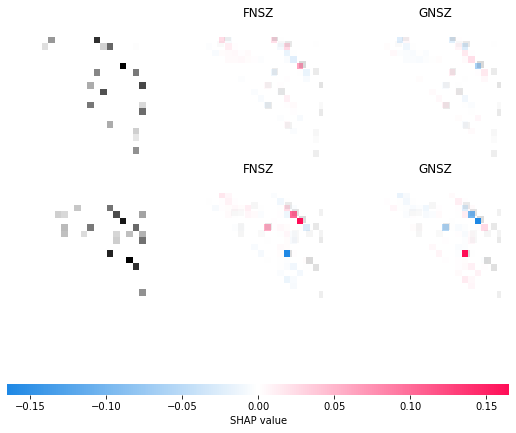

In [171]:
tries = random.sample(idx, 2)
test_images = images[tries]

shap_values_short = e.shap_values(test_images)

shap_numpy_short = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_short]
test_numpy_short = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

classess = ['FNSZ','GNSZ']
im_names = np.vectorize(lambda x : classess[x])([y_true[j] for j in tries]).tolist()
# Add im_namees text to the left of the figure
labels = np.array(len(test_images)*[classess])

shap_numpy_short_adj, test_numpy_short_adj =keep_adj(shap_numpy_short, test_numpy_short, x=1)

# plot the feature attributions
print('True class of graph on the left (top to bottom) :',im_names)
shap.image_plot(shap_numpy_short_adj, -test_numpy_short_adj, labels=labels, labelpad=20)

In [131]:
shap_values = e.shap_values(background) # Computationally heavy on all images

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [292]:
shap_numpy_adj = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2)[:,:,:,1] for s in shap_values]

# Select the arrays of SHAP values when classifying as FNSZ of the graphs that were rightly classified as FNSZ
FNSZ_shaps = shap_numpy_adj[0][idx_FNSZ]
# Select the arrays of SHAP values when classifying as GNSZ of the graphs that were rightly classified as GNSZ
GNSZ_shaps = shap_numpy_adj[1][idx_GNSZ]


(20, 20)
(20, 20)


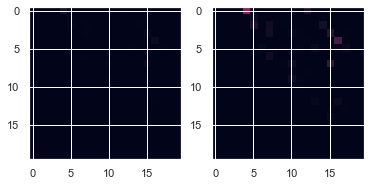

In [293]:
print(np.sum(GNSZ_shaps,axis=0).shape)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(GNSZ_shaps[4], vmin=0, vmax=1)
ax[1].imshow(GNSZ_shaps[4]/np.sum(GNSZ_shaps[4]), vmin=0, vmax=1)

#plt.imshow(GNSZ_shaps[4])
print((GNSZ_shaps[4]/np.sum(GNSZ_shaps[4])).shape)

In [305]:
def class_shap_pixels(class_shaps) :
    shaps = class_shaps
    for i in range(len(class_shaps)) :
        
        # Detect all the pixels that show a positive 
        shaps[i] = np.sign(shaps[i])
        # ReLU the matrix
        shaps[i] = np.maximum(shaps[i], 0)
        # Divide by the sum of all elements (to penalise overall contribution of over-connected matrices)
        #shaps[i] = shaps[i]/np.sum(shaps[i]) 

    # Sum all the shap arrays into one
    graph = np.sum(shaps,axis=0)

    return graph/np.amax(graph.flatten())

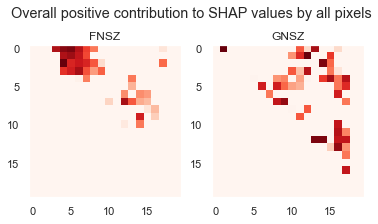

In [306]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.set_theme()
ax[0].imshow(class_shap_pixels(FNSZ_shaps), vmin=0.8, vmax=1, cmap='Reds')
ax[0].set_title('FNSZ')
ax[0].grid(False)
ax[1].imshow(class_shap_pixels(GNSZ_shaps), vmin=0.8, vmax=1, cmap='Reds')
ax[1].set_title('GNSZ')
ax[1].grid(False)
fig.suptitle('Overall positive contribution to SHAP values by all pixels', y=0.9);

In [ ]:
GE = shap.GradientExplainer(dual_CNN, background)
shap_values_GE, indexes = e.shap_values(test_images)

classess = ['FNSZ','GNSZ']
im_names = np.vectorize(lambda x : classess[x])([y_true[j] for j in tries]).tolist()
# Add im_namees text to the left of the figure
labels = np.array(len(test_images)*[classess])

# plot the explanations
shap_values_GE = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values_GE]

shap.image_plot(shap_values_GE, test_images, labels=labels)